## Closing the mass budget within layers
[This tutorial is a work-in-progress, and will be updated frequently.]  

Transformation $G$ (see watermass transformation tutorial) represents a mass flux across layers of constant $\lambda$. For a time-varying system within a fixed region ($\mathscr{R}$) with boundaries in the ocean interior ($\partial\mathscr{R}_{int}$) and at the ocean surface ($\delta\mathscr{R}_{surf}$), $G$ will be balanced by temporal mass changes and mass transport across the fixed boundaries (see Section 2.3 in Groeskamp et al., 2019):
$$ G = -\frac{dM}{dt} - \psi + W $$
where
$$M = \iiint_{\mathscr{R}(\lambda'\leq\lambda)} \rho dV\,; \quad \psi = \iint_{\partial\mathscr{R}_{int}(\lambda'\leq\lambda)} (\rho\mathbf{u})\cdot\mathbf{\hat{n}}dR\,; \quad W = \iint_{\partial\mathscr{R}_{surf}(\lambda'\leq\lambda)} \rho F dR\,,$$
are, respectively, the total mass in the region, the mass flux across the interior ocean boundary ($\mathbf{\hat{n}}$ is normal to the boundary), and the mass flux across the ocean surface ($F$ is the local balance of air-sea and ice-sea volume fluxes), where each integration is performed over the region in which $\lambda'\leq\lambda$.  

Here, we evaluate each of the terms in this expression and assess how well the budget closes. Again, we consider the Baltic Sea test case. For this case, the lateral boundaries are closed, so that $\psi=0$.

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xgcm import Grid

In [142]:
# Load data on native grid
rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/1yr/'
gridname = 'native'
prefix = '19000101.ocean_'
# Diagnostics were saved into different files
suffixs = ['1900','heat','salt']
ds = xr.Dataset()
for suffix in suffixs:
    filename = prefix+gridname+'_'+suffix+'*.nc'
    dsnow = xr.open_mfdataset(rootdir+filename)
    ds = xr.merge([ds,dsnow])
# Load snapshot data
suffix = 'snap'
filename = prefix+gridname+'_'+suffix+'*.nc'
snap = xr.open_mfdataset(rootdir+filename)
#  Load grid
gridname = '19000101.ocean_static.nc'
grid = xr.open_dataset(rootdir+gridname).squeeze()

# Specify the diffusive tendency terms
processes=['boundary forcing','vertical diffusion','neutral diffusion','frazil ice','internal heat']
terms = {}
terms['heat'] = {'boundary forcing':'boundary_forcing_heat_tendency',
         'vertical diffusion':'opottempdiff',
         'neutral diffusion':'opottemppmdiff',
         'frazil ice':'frazil_heat_tendency',
         'internal heat':'internal_heat_heat_tendency'}
# Specify the tracer range and bin widths (\delta\lambda) for the calculation
delta_l = 0.2
lmin = -4
lmax = 30
bins = np.arange(lmin,lmax,delta_l)
# Specify constants for the reference density and the specific heat capacity
rho0 = 1035.
Cp = 3992.

In [143]:
# Build an xgcm grid object
# Create a pseudo-grid in the vertical
grid['zl'] = ds['zl']
grid['zi'] = ds['zi']
grid['dzt'] = grid['zl'].copy(data=grid['zi'].diff('zi'))
grid = grid.squeeze() # Get rid of any remnant time variables

# Fill in nans with zeros
grid['dxt'] = grid['dxt'].fillna(0.)
grid['dyt'] = grid['dyt'].fillna(0.)
grid['dzt'] = grid['dzt'].fillna(0.)
grid['areacello'] = grid['areacello'].fillna(0.)
grid['volcello'] = (ds['thkcello']*grid['areacello']).fillna(0.)
metrics = {
    ('X',): ['dxt','dxCu','dxCv'], # X distances
    ('Y',): ['dyt','dyCu','dyCv'], # Y distances
    ('Z',): ['dzt'], # Z distances
    ('X', 'Y'): ['areacello'], # Areas
    ('X', 'Y', 'Z'): ['volcello'], # Volumes
}
coords={'X': {'center': 'xh', 'right': 'xq'},
        'Y': {'center': 'yh', 'right': 'yq'},
        'Z': {'center': 'zl', 'outer': 'zi'} }
xgrid = Grid(grid, coords=coords, metrics=metrics, periodic=['X'])

# Interpolate the temperature coordinate to the cell interfaces
ds['temp_i'] = xgrid.interp(ds['temp'],'Z',boundary='extrapolate').chunk({'zi':-1})
# Likewise for the snapshot temperature
snap['temp_i'] = xgrid.interp(snap['temp'],'Z',boundary='extrapolate').chunk({'zi':-1})

## Budget in temperature layers

### Calculating $G$

In [144]:
# Transform each of the diffusive tendency terms onto a temperature grid
# And integrate in each temperature layer and divide by \delta temp
G = xr.Dataset()
for process in processes:
    term = terms['heat'][process]
    var_on_temp = xgrid.transform(ds[term],'Z',target=bins,target_data=ds['temp_i'],method='conservative')
    G[process] = ((rho0*var_on_temp/(rho0*Cp))*grid['areacello']).sum(['xh','yh'])/np.diff(bins)
# Sum up the separate processes
G['total'] = xr.zeros_like(G[processes[0]])
for process in processes:
    G['total']+=G[process]

### Calculating $\frac{dM}{dt}$

[Under construction]

To assess the temporal change of a volume defined by a moving contour, we need to track that contour over time. Since we are necessarily working with offline data in this instance, it is only possible to evaluate $\frac{dM}{dt}$ from snapshots of the temperature field at the start and end of the averaging period.

#### Calculate M in each layer and integrate
At this step, you need to be particularly careful in the alignment of the contours. The calculation of $G$ above evaluates the transformation across contours in the middle of `bins`. As such, the corresponding $M$ should be the cumulative sum of volumes in layers greater than the central contour. As such, we redefine the `bins` for the transformation of the volume.

In [145]:
# Transform snapshot mass onto snapshot temperature grid
m_on_temp = xgrid.transform(rho0*snap['thkcello'],
                               'Z',
                               target=G['temp_i'],
                               target_data=snap['temp_i'],
                               method='conservative')
# Integrate
M_on_temp = (m_on_temp*grid['areacello']).sum(['xh','yh'])

In [146]:
# To integrate for all volume with temperature greater than a certain value,
# take cumulative sum and reassign the coordinates to align with G
M_on_temp_cumsum = xr.concat([xr.zeros_like(M_on_temp.isel({'temp_i':0})),M_on_temp.cumsum('temp_i')],dim='temp_i')
# We wish to have the total mass for the volume with temperature greater than that contour,
# So take away the total sum from the cumulative sum to reverse the direction
M = (M_on_temp.sum('temp_i')-M_on_temp_cumsum).assign_coords({'temp_i':G['temp_i']})

#### Take the derivative in time

In [147]:
dMdt = M.diff('time')/(M['time'].diff('time').astype('float')*1E-9)
# Assign the coordinates to align with G (centre of the averaging period)
dMdt = dMdt.assign_coords({'time':G['time'][1:]})

### Calculating $W$
We can get the surface mass flux from the boundary thickness fluxes. Integrate just as we did for $M$.

In [148]:
# Transform snapshot mass onto snapshot temperature grid
w_on_temp = xgrid.transform(rho0*ds['boundary_forcing_h_tendency'],
                               'Z',
                               target=G['temp_i'],
                               target_data=ds['temp_i'],
                               method='conservative')
# Integrate
W_on_temp = (w_on_temp*grid['areacello']).sum(['xh','yh'])

In [149]:
# To integrate for all volume with temperature greater than a certain value,
# take cumulative sum and reassign the coordinates to align with G
W_on_temp_cumsum = xr.concat([xr.zeros_like(W_on_temp.isel({'temp_i':0})),W_on_temp.cumsum('temp_i')],dim='temp_i')
# We wish to have the total mass for the volume with temperature greater than that contour,
# So take away the total sum from the cumulative sum to reverse the direction
W = (W_on_temp.sum('temp_i')-W_on_temp_cumsum).assign_coords({'temp_i':G['temp_i']})

### Plot the budget
We note that in the time-mean, as plotted here, the budget does not close. In particular, for the warm waters, there is non-zero time-mean watermass transformation, whereas the rate of change of mass goes to zero. This is likely to arise from either numerical mixing in the model, errors in the discrete nature of the water mass transformation calculatioon, or errors from the use of temporally-averaged offline diagnostic fields.

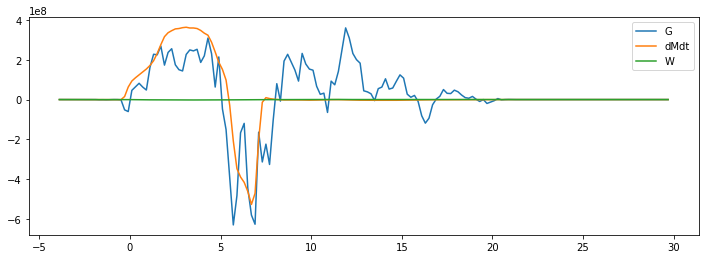

In [150]:
# Remember that G and W have one more timestep than dMdt
# So we select a time range to be sure that we are getting
# the same points.
select = {'time':slice('1900-02-01','1900-12-31')}

t=0
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(G['temp_i'],G['total'].sel(select).mean('time'),color='tab:blue',label='G')
ax.plot(dMdt['temp_i'],dMdt.sel(select).mean('time'),color='tab:orange',label='dMdt')
ax.plot(W['temp_i'],W.sel(select).mean('time'),color='tab:green',label='W')
ax.legend()